<a href="https://colab.research.google.com/github/mj0410/GoogleNet/blob/main/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoogLeNet
- binary classification of AI generated dog images and real pictures
- images collected from google images

### Import Packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import PIL
import glob, os
from sklearn.model_selection import train_test_split

### Load Dataset

In [ ]:
#!mkdir dataset
#!unzip /content/drive/MyDrive/NVIDIA/googlenet/dataset.zip -d /content/drive/MyDrive/NVIDIA/googlenet/dataset

In [2]:
dataset_folder_path = '/content/drive/MyDrive/NVIDIA/googlenet/dataset'
category_cnt = os.listdir(dataset_folder_path)

In [3]:
glob.glob(os.path.join(dataset_folder_path, '*'))

['/content/drive/MyDrive/NVIDIA/googlenet/dataset/generated',
 '/content/drive/MyDrive/NVIDIA/googlenet/dataset/new',
 '/content/drive/MyDrive/NVIDIA/googlenet/dataset/pictures']

In [4]:
pics = glob.glob(os.path.join(dataset_folder_path, 'pictures', '*'))
pics = [pic for pic in pics if pic.endswith('jpg') or pic.endswith('jpeg')]

paints = glob.glob(os.path.join(dataset_folder_path, 'generated', '*'))
paints = [paint for paint in paints if paint.endswith('jpg') or paint.endswith('jpeg')]

In [5]:
print(len(pics), "pictures, example : ", pics[0])
print(len(paints), "paintings, example : ", paints[0])

552 pictures, example :  /content/drive/MyDrive/NVIDIA/googlenet/dataset/pictures/dogs (112).jpg
565 paintings, example :  /content/drive/MyDrive/NVIDIA/googlenet/dataset/generated/generated (15).jpeg


### Data Preprocessing

In [6]:
x, y = [], []
img_width, img_height = 128, 128
training_path = [p for p in glob.glob(os.path.join(dataset_folder_path, '*')) if not p.endswith('new')]
training_path

['/content/drive/MyDrive/NVIDIA/googlenet/dataset/generated',
 '/content/drive/MyDrive/NVIDIA/googlenet/dataset/pictures']

In [7]:
for label, folder in enumerate(training_path):
  for idx, file in enumerate(glob.glob(os.path.join(folder, '*'))):
    if file.endswith('jpg') or file.endswith('jpeg'):
      image = PIL.Image.open(file)
      image = image.resize((img_width, img_height))
      image = image.convert('RGB')
      np_image = np.asarray(image)
      x.append(np_image)
      y.append(label)

In [8]:
x = np.array(x)
y = np.array(y)

In [9]:
print("number of images of each category :", np.bincount(y))
print(x.shape, y.shape)

number of images of each category : [565 552]
(1117, 128, 128, 3) (1117,)


development tips!

```
xy = (x_train, x_test, y_train, y_test)
np.save('/content/drive/Mydrive/NVIDIA/googlenet/preprocessing.npy', xy)
```

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [11]:
x_train = x_train / 255.
x_test = x_test / 255.

### Build Model

##### Inception

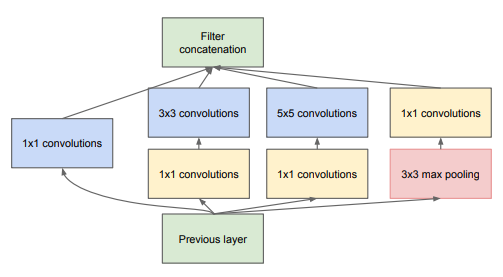

In [12]:
def inception(input_layer, filter):

  tower_1 = layers.Conv2D(filters = filter, kernel_size = (1, 1), strides = 1, padding = 'same', activation = 'relu')(input_layer)

  tower_2 = layers.Conv2D(filters = filter, kernel_size = (1, 1), strides = 1, padding = 'same', activation = 'relu')(input_layer)
  tower_2 = layers.Conv2D(filters = filter, kernel_size = (3, 3), strides = 1, padding = 'same', activation = 'relu')(tower_2)

  tower_3 = layers.Conv2D(filters = filter, kernel_size = (1, 1), strides = 1, padding = 'same', activation = 'relu')(input_layer)
  tower_3 = layers.Conv2D(filters = filter, kernel_size = (5, 5), strides = 1, padding = 'same', activation = 'relu')(tower_3)

  tower_4 = layers.MaxPool2D(pool_size = (3, 3), strides = 1, padding='same')(input_layer)
  tower_4 = layers.Conv2D(filters = filter, kernel_size = (1, 1), strides = 1, padding = 'same', activation = 'relu')(tower_4)

  concat_layer = layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)

  return concat_layer

In [13]:
input_layer = layers.Input(shape = (img_width, img_height, 3))

concat_layer_1 = inception(input_layer, 64)
concat_layer_2 = inception(concat_layer_1, 120)

average_pooling_layer = layers.AveragePooling2D(pool_size = (16, 16), strides = (16, 16), padding='valid')(concat_layer_2)

flat_layer = layers.Flatten()(average_pooling_layer)

dense_layer = layers.Dense(128, activation='relu')(flat_layer)
output_layer = layers.Dense(1, activation='sigmoid')(dense_layer)

google_net_model = models.Model(inputs = input_layer, outputs = output_layer)
google_net_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         256       ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 128, 128, 64)         256       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 3)          0         ['input_1[0][0]']             
 D)                                                                                           

In [15]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps = 8 * 45,
    decay_rate = 0.96,
    staircase = True
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule, ema_momentum=0.9) #, momentum=0.9)
google_net_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [16]:
checkpoint_path = '/content/drive/MyDrive/NVIDIA/googlenet/checkpoint'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
history = google_net_model.fit(x_train, y_train, batch_size=16, epochs=50,
                               validation_split=0.2,
                               callbacks=[checkpoint, early_stopping])

Epoch 1/50
45/45 [==============================] - 42s 575ms/step - loss: 6.1766 - acc: 0.5910 - val_loss: 0.5336 - val_acc: 0.7654
Epoch 2/50
45/45 [==============================] - 11s 247ms/step - loss: 0.5272 - acc: 0.7577 - val_loss: 0.5929 - val_acc: 0.6983
Epoch 3/50
45/45 [==============================] - 12s 258ms/step - loss: 0.5187 - acc: 0.7675 - val_loss: 0.5962 - val_acc: 0.7709
Epoch 4/50
45/45 [==============================] - 14s 314ms/step - loss: 0.4698 - acc: 0.7927 - val_loss: 0.4789 - val_acc: 0.7765
Epoch 5/50
45/45 [==============================] - 11s 249ms/step - loss: 0.4474 - acc: 0.7955 - val_loss: 0.4974 - val_acc: 0.7933
Epoch 6/50
14/45 [========>.....................] - ETA: 7s - loss: 0.4247 - acc: 0.8125

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Inference

In [ ]:
!mkdir checkpoint
!unzip /content/checkpoint.zip -d /content/drive/MyDrive/NVIDIA/googlenet/checkpoint

In [ ]:
checkpoint_path = '/content/drive/MyDrive/NVIDIA/googlenet/checkpoint'
google_net_model.load_weights(checkpoint_path)

In [ ]:
test = PIL.Image.open('/content/generated.jpg')
test = test.resize((64, 64))
test = test.convert('RGB')
np_test = np.asarray(test)
test_image_tensor = np.array([np_test])
test_image_tensor = test_image_tensor / 255.

In [ ]:
result = google_net_model.predict(test_image_tensor)
result

1/1 [==============================] - 0s 121ms/step


array([[0.9610998]], dtype=float32)